In [1]:
from Functions import *
import scipy.interpolate as interpolate
import winsound

In [2]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 50000		# total simulation time window [fs]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 650-26
}

In [3]:
##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'beam_profiles/'; make_dir(dir_case)

print('\nCWD:',dir_case)

path exists
path exists
path exists

CWD: output/9481eV/beam_profiles/


In [4]:
##### OE parameters
l_crystal = [0.049240000000000006, 0.03546, 0.03546, 0.049240000000000006, 0.00368, 0.00296]
w_crystal = [0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528, 0.001985351760528]
shapeErrors = [None for i in range(6)]


In [5]:
def define_beamline(
    E0, slit_width, m2_p=175.5, shapeErrors=[None for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=256)
    
    ## Telescope
    m1 = optics.CurvedMirror('M1',p=185,q=-58,length=1,z=185+z_s,alpha=2.65e-3)
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=256)
    
    m2 = optics.CurvedMirror('M2',p=m2_p,q=1e5,length=1,z=300+z_s,alpha=2.65e-3,orientation=2)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=256)
    
    ## HHLM
    asym = np.deg2rad(9)
    hhlm1 = optics.Crystal('HHLM1', hkl=[1,1,1], length=l_crystal[0], width=w_crystal[0], z=305+z_s, alphaAsym=-asym, E0=E0, 
                           orientation=0, pol='s', shapeError=shapeErrors[0])
    im_after_HHLM1 = optics.PPM('im_after_HHLM1', FOV=30e-3,N=256,z=hhlm1.z+.01)
    
    hhlm2 = optics.Crystal('HHLM2', hkl=[4,4,0], length=l_crystal[1], width=w_crystal[1], z=hhlm1.z+139e-3, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[1])
    im_after_HHLM2 = optics.PPM('im_after_HHLM2', FOV=30e-3,N=256,z=hhlm2.z+.01)
    
    hhlm3 = optics.Crystal('HHLM3', hkl=[4,4,0], length=l_crystal[2], width=w_crystal[2], z=hhlm1.z+361e-3, E0=E0,
                           orientation=0, pol='s', shapeError=shapeErrors[2])
    im_after_HHLM3 = optics.PPM('im_after_HHLM3', FOV=30e-3,N=256,z=hhlm3.z+.01)
    
    hhlm4 = optics.Crystal('HHLM4', hkl=[1,1,1], length=l_crystal[3], width=w_crystal[3], z=hhlm1.z+.5, alphaAsym=asym, E0=E0,
                           orientation=2, pol='s', shapeError=shapeErrors[3])
    im_after_HHLM4 = optics.PPM('im_after_HHLM4', FOV=30e-3,N=256,z=hhlm4.z+.01)
    
    ## HRM
    alphaAsym = np.deg2rad(15)    # crystal asymmetry angle
    hkl = [4,4,0]    # crystal plane
    f1 = 10.    # crystal-lens/mirror distance
    f2 = 10.    # lens/mirror focal distance
    
    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('C1', hkl=hkl, length=l_crystal[4], width=w_crystal[4], z=z_s+310, E0=E0, alphaAsym=0, 
                              orientation=0, pol='s', delta=0.e-6, shapeError=shapeErrors[4])
    im_after_C1 = optics.PPM('im_after_C1', z=crystal1.z+.01, FOV=5e-3, N=256)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('C2', hkl=hkl, length=l_crystal[5], width=w_crystal[5], z=crystal1.z+.05, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2, pol='s', delta=0e-6, shapeError=shapeErrors[5])

    im_after_C2 = optics.PPM('im_after_C2', z=crystal2.z+.01, FOV=5e-3, N=256)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # elliptical mirror with ~10 meter focal length
    im_before_MIR1 = optics.PPM('im_before_MIR1', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)
    mir1 = optics.CurvedMirror('mir1', z=crystal2.z+f1, p=1e5, q=f2, length=1.0, width=5e-3, alpha=3e-3, orientation=0)
    im_after_MIR1 = optics.PPM('im_after_MIR1', z=mir1.z+.1, FOV=5e-3, N=256)

    # slit at focus
    slit = optics.Slit('Slit', z=mir1.z+f2, x_width=slit_width, y_width=2e-3)
    print('slit width: {} um'.format(slit.x_width*1e6))

    # viewing point at focus
    im_focus = optics.PPM('im_focus', z=mir1.z+f2 + 1e-3, FOV=50e-6, N=256)

    # elliptical mirror with ~10 meter focal length, for collimation
    im_before_MIR2 = optics.PPM('im_before_MIR2', z=mir1.z+2*f2 -.1, FOV=2e-3, N=256)
    mir2 = optics.CurvedMirror('mir2', z=mir1.z+2*f2, p=f2, q=1e5, length=1.0, width=5e-3, alpha=3e-3, orientation=2)
    im_after_MIR2 = optics.PPM('im_after_MIR2', z=mir2.z+.1, FOV=2e-3, N=256)
    
    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('C3', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+f1, E0=E0,alphaAsym=-alphaAsym,
                              orientation=2, pol='s')
    im_after_C3 = optics.PPM('im_after_C3', z=crystal3.z+.01, FOV=5e-3, N=256)

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('C4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.05, E0=E0,alphaAsym=0, 
                              orientation=0, pol='s')
    im_out = optics.PPM('im_out', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    telescope_devices = [im_input, m1, im_after_T1, m2, im_after_T2]
    HHLM_devices = [hhlm1, im_after_HHLM1, hhlm2, im_after_HHLM2, hhlm3, im_after_HHLM3, hhlm4, im_after_HHLM4]
    HRM_devices = [crystal1,im_after_C1, crystal2,im_after_C2, im_before_MIR1,mir1,im_after_MIR1, slit,im_focus,
               im_before_MIR2,mir2,im_after_MIR2, crystal3,im_after_C3, crystal4,im_out]
    
    all_devices = telescope_devices + HHLM_devices + HRM_devices
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return mono_beamline

### Calculate slit width

In [6]:
%%capture capt
##### perfect case
m2_p = 175.83333333333331
mono_beamline = define_beamline(E0,200e-6, m2_p = m2_p)

''' propagate '''
b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [10]:
##### get grazing out angles
crystal_names = ['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']

for device in mono_beamline.device_list:
    if device.name in crystal_names:
        print(device.name, device.beta0)

HHLM1 0.3671667298651142
HHLM2 0.7492421541043375
HHLM3 0.7492421541043375
HHLM4 0.053143614232789516
C1 0.7492421541043375
C2 0.4874726424983002


In [9]:
def calc_slit_width(inbeam, lmbd, foc):
    # inbeam is the beamsize (2x FWHM) after Crystal 2
    # lmbd is wavelength of photon
    # asym is asymmetry angle of Crystal 2
    # foc is Mir1/Lens1 focal distance
    # returns mono focus size in [m] at the Fourier plane
    slt = 2*np.log(2)*lmbd*foc/np.pi/inbeam
    return 2.11 * slt    # 2x FWHM with some error (~factor of 5%)

wx = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2]

if_close = 1
if if_close == 1:
    slit_width = calc_slit_width(wx*2, b2.lambda0, mono_beamline.mir1.q)
    slit_width = 3e-6
else:
    slit_width = 1e-2

print('slit width: {}um\n'.format(round(slit_width*1e6,2)))

mono_beamline = define_beamline(E0,slit_width, m2_p = m2_p)

slit width: 3.0um

b 0.15
b 1.00
b 1.00
b 6.76
b 1.00
b 1.81
crystal 2 incidence angle: 57.93 degrees
crystal 2 exit angle: 27.93 degrees
slit width: 3.0 um
b 0.55
b 1.00


### Beam profiles along the beamline

In [10]:
%%capture capt
#### Time domain propagation
beam_params['photonEnergy'] = E0

pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=500)

screen_names = ['im_input', 'im_after_T1', 'im_after_T2', 'im_after_HHLM1', 'im_after_HHLM2', 'im_after_HHLM3', 'im_after_HHLM4',
    'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

# screen_names = ['im_focus', 'im_out']
pulse.propagate(beamline=mono_beamline, screen_names=screen_names)


In [11]:
''' diagnostics '''
c, pulse_duration0 = pulse.pulse_duration('im_out')
pulse_tilt0 = pulse.pulsefront_tilt('im_out')
spatial_chirp0 = pulse.spatial_chirp('im_out')
energy_bandwidth0 = pulse.pulse_bandwidth('im_out')

print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))

duration 871fs
tilt -0.3347248120300674fs/um
spatial chirp 1.8646179084476334e-05meV/um
bandwidth 2.727294796255566meV


path exists


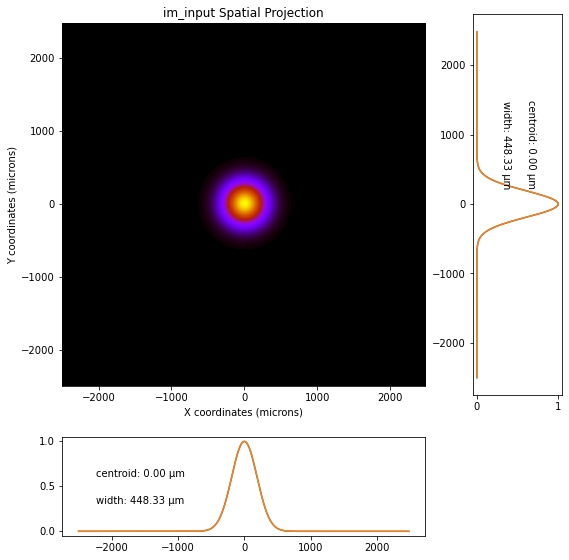

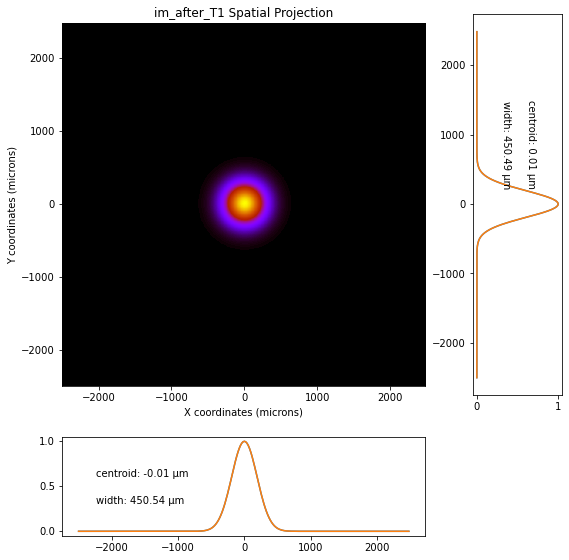

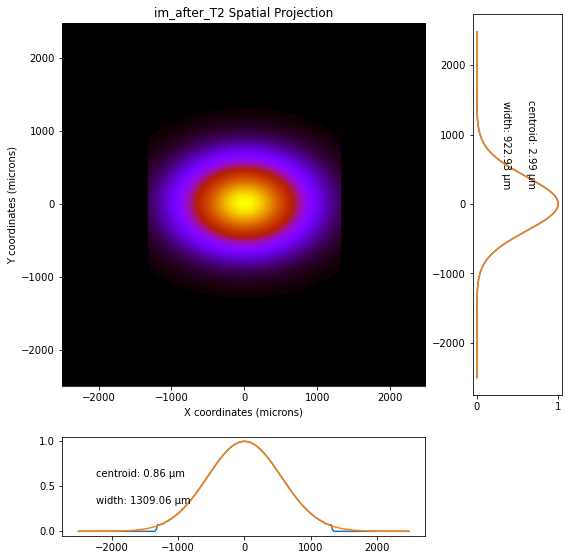

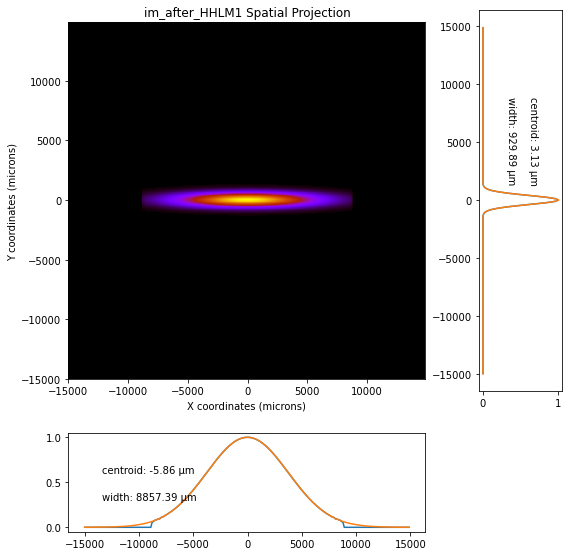

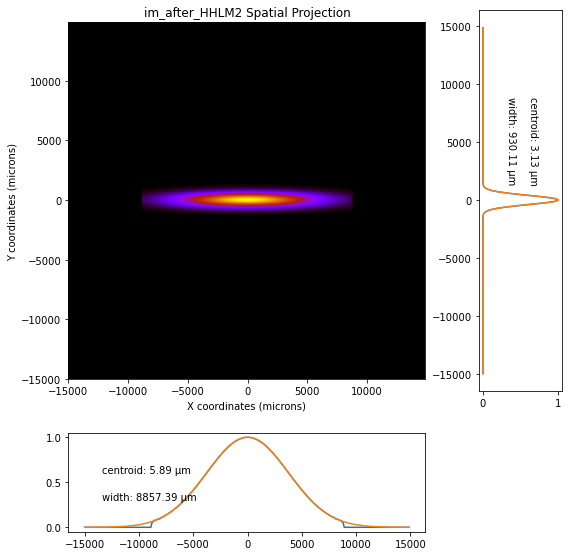

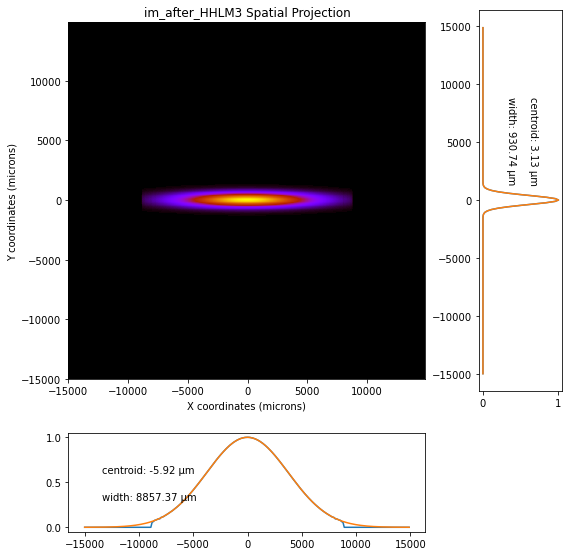

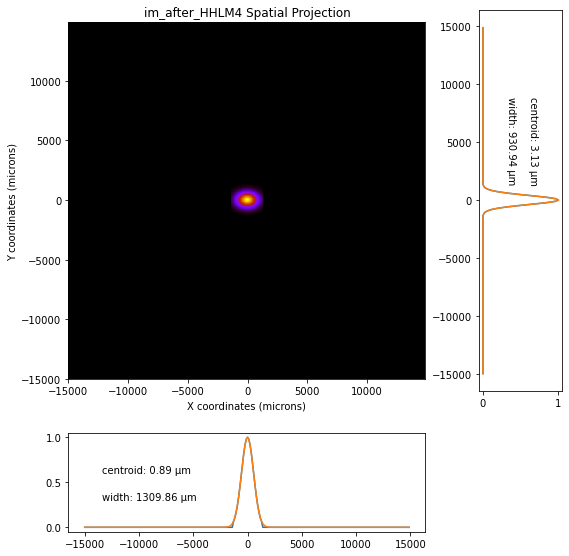

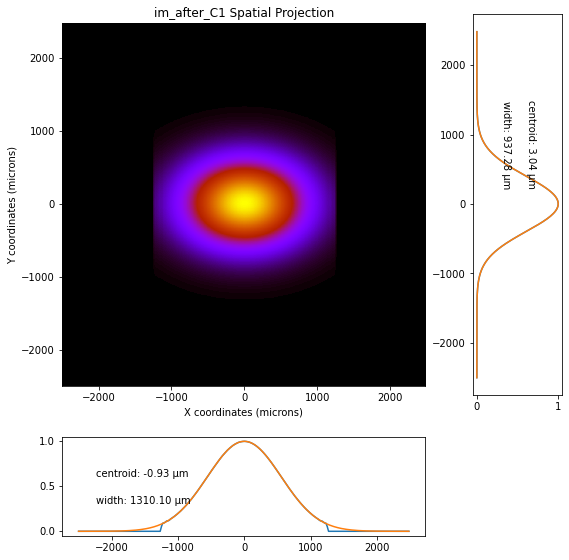

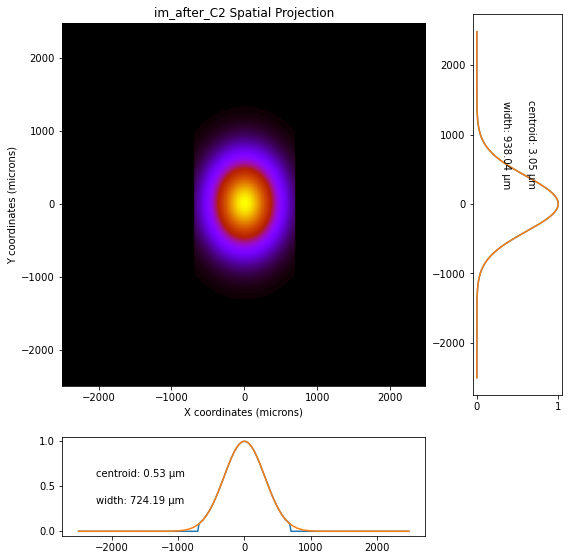

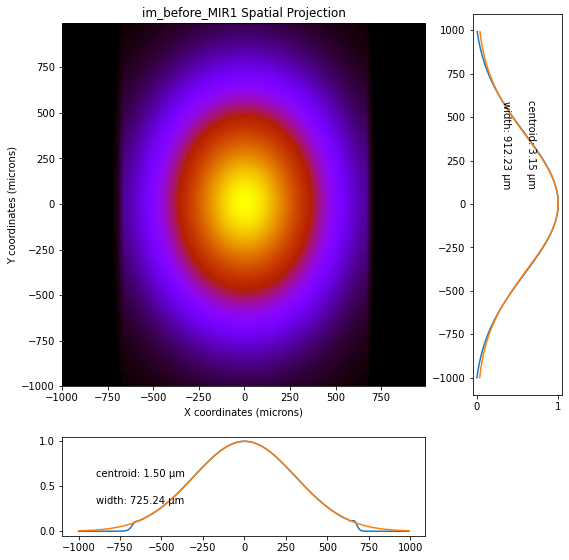

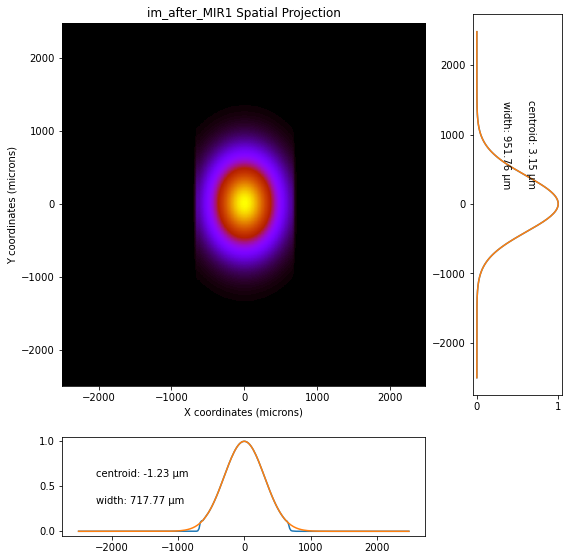

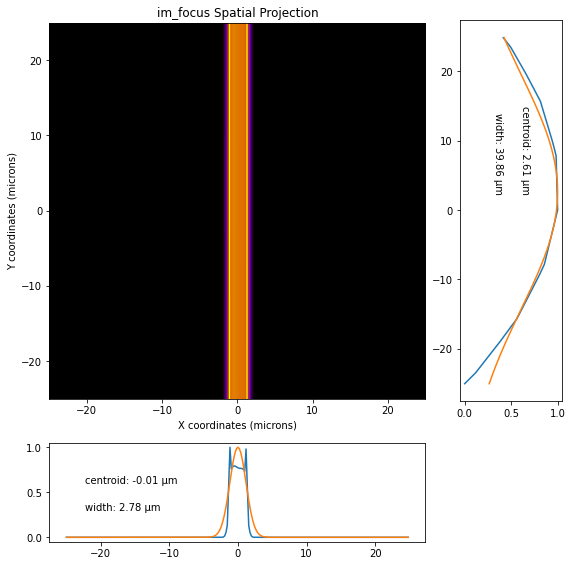

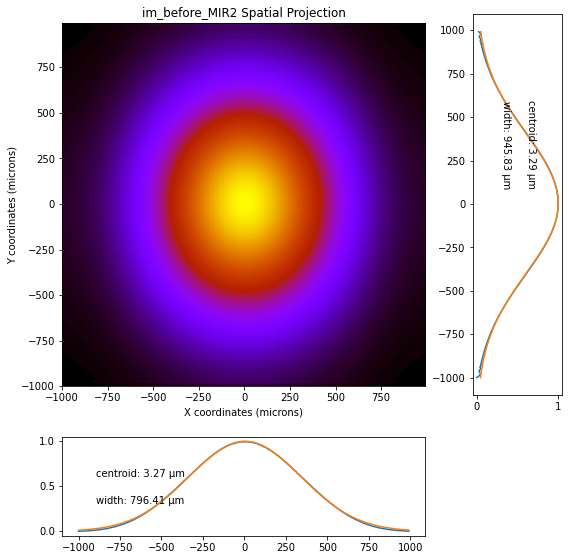

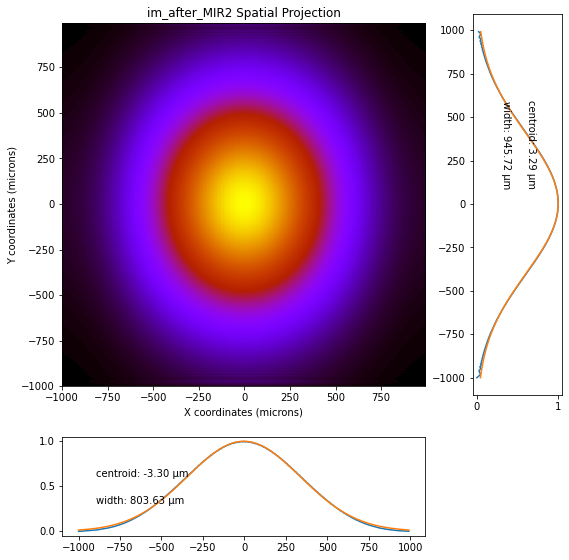

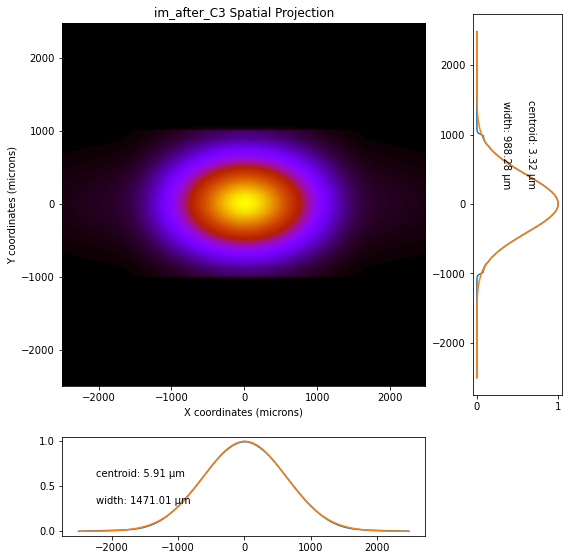

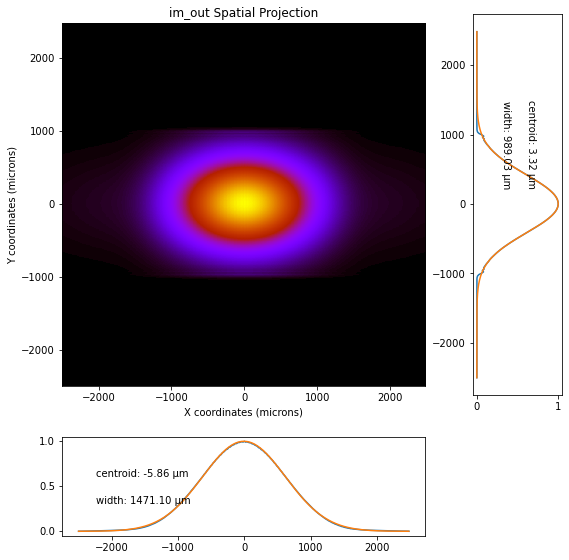

In [12]:
''' projection '''
dir_perfect = dir_case + 'perfect_M2_p={}m/'.format(m2_p); make_dir(dir_perfect)
for screen_name in pulse.screens:
    try:
        pulse.imshow_projection(screen_name)
        if if_close == 1:
            plt.savefig(dir_perfect+'projection_{}_close.png'.format(screen_name))
        else:
            plt.savefig(dir_perfect+'projection_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')

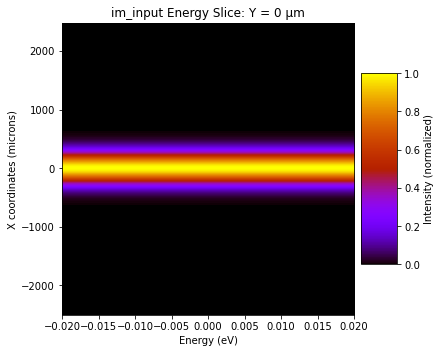

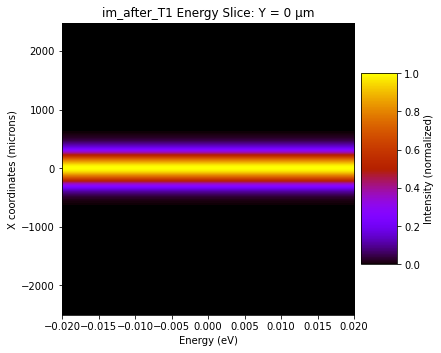

In [ ]:
''' energy slices '''
for screen_name in pulse.screens:
    try:
        pulse.imshow_energy_slice(screen_name)
        if if_close == 1:
            plt.savefig(dir_perfect+'spectrum_{}_close.png'.format(screen_name))
        else:
            plt.savefig(dir_perfect+'spectrum_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')


In [ ]:
''' plot time slices '''
shift = 0
for screen_name in pulse.screens:
    try:
        pulse.imshow_time_slice(screen_name, shift=shift)
        if if_close == 1:
            plt.savefig(dir_perfect+'tilt_{}_close.png'.format(screen_name))
        else:
            plt.savefig(dir_perfect+'tilt_{}.png'.format(screen_name))
    except:
        print(screen_name, 'failed')

In [ ]:
import winsound
winsound.Beep(1500, 3000)